In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

# data_dir = "../../../gnode/experiment_analysis/dat/"
# data_dir = "../data"
# data_dir = "/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data"
data_dir = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat")


2024-05-24 22:13:47,365 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis


In [79]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-05-24 23:04:09,897 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2024-05-24 23:04:09,899 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN


In [80]:
# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
len_before = len(meta_df)
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("tau_R >= 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-05-24 23:04:14,432 | INFO     | notebook | <module> | removed 923 rows due to unexpected timescales


In [81]:
df = meta_df.query("block in ['merged_3.0_and_8.0', 'null']")
df["tau_R"].min()

0.0

2024-05-25 02:01:52,970 | INFO     | plot_helper | panel_selectivity_violin | violins for R_tot, ['natural_movie_one_more_repeats' 'spontaneous'], N=5017
2024-05-25 02:01:52,976 | INFO     | plot_helper | panel_selectivity_violin | natural_movie_one_more_repeats vs spontaneous diff=22.3% p=1.0610568858865772e-235
2024-05-25 02:01:53,576 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats median: 0.0802 quantiles: [0.07871836 0.08177546] from 500 samples of length 5017
2024-05-25 02:01:53,577 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats min: -0.0018 max: 0.37
2024-05-25 02:01:54,158 | DEBUG    | plot_helper | fancy_violins | spontaneous median: 0.0631 quantiles: [0.06182059 0.06429493] from 500 samples of length 5017
2024-05-25 02:01:54,159 | DEBUG    | plot_helper | fancy_violins | spontaneous min: -7.4e-05 max: 0.47
2024-05-25 02:01:54,168 | DEBUG    | plot_helper | fancy_violins | plotting 800 points for cat stimulus
2024-05-25 02:01

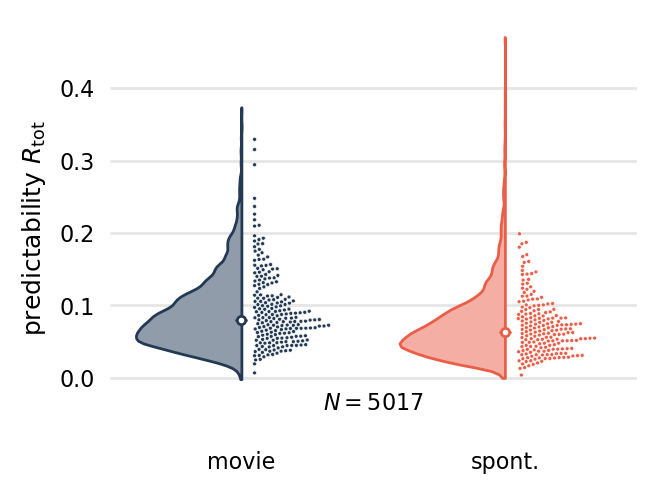

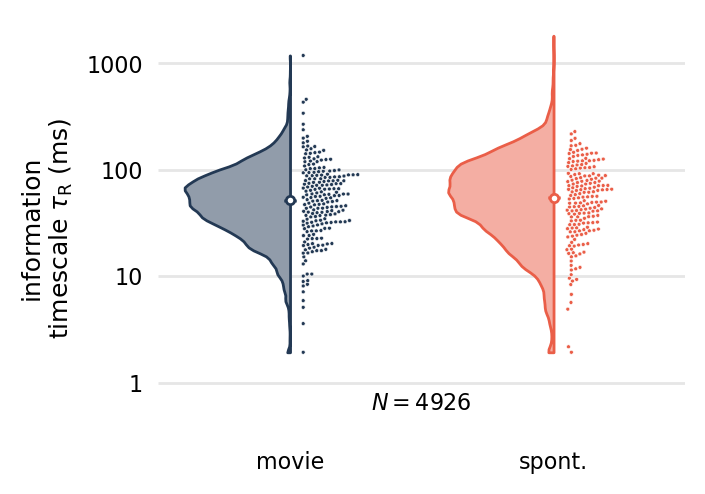

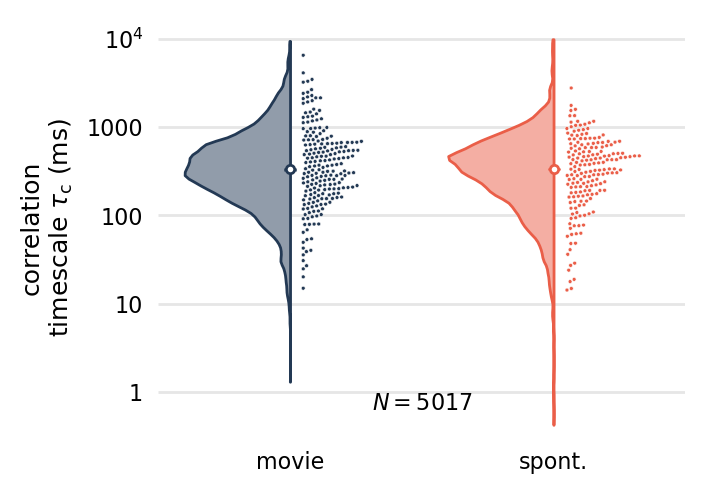

In [122]:
import seaborn as sns

for obs in ["R_tot", "tau_R", "tau_double"]:
    ax = ph.panel_selectivity_violin(
        df = meta_df.query("block in ['merged_3.0_and_8.0', 'null']"),
        observable = obs,
        logscale=False if obs == "R_tot" else True,
        category = "stimulus",
        num_swarm_points=400,
        xlabels = ['movie', 'spont.'],
        # specify palette to make sure labels are correct!
        palette={
                "natural_movie_one_more_repeats" : "#233954",
                "spontaneous" : "#EA5E48",
            },
    )


2024-05-24 22:13:57,136 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 median: 0.0795 quantiles: [0.07795181 0.08079835] from 500 samples of length 5350
2024-05-24 22:13:57,136 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 min: -0.0018 max: 0.39
2024-05-24 22:13:57,561 | DEBUG    | plot_helper | fancy_violins | null median: 0.0636 quantiles: [0.06211673 0.06467466] from 500 samples of length 5495
2024-05-24 22:13:57,561 | DEBUG    | plot_helper | fancy_violins | null min: -0.002 max: 0.47
2024-05-24 22:13:57,569 | DEBUG    | plot_helper | fancy_violins | plotting 800 points for cat block
2024-05-24 22:13:58,141 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 median: 0.0530 quantiles: [0.05165953 0.05449285] from 500 samples of length 5350
2024-05-24 22:13:58,142 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 min: 0 max: 1.2
2024-05-24 22:13:58,567 | DEBUG    | plot_helper | fancy_violins | null median: 0.0538 quantiles: [0.052

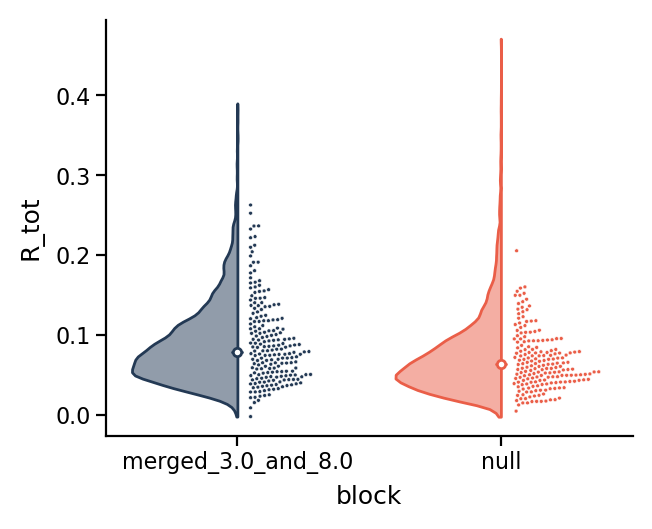

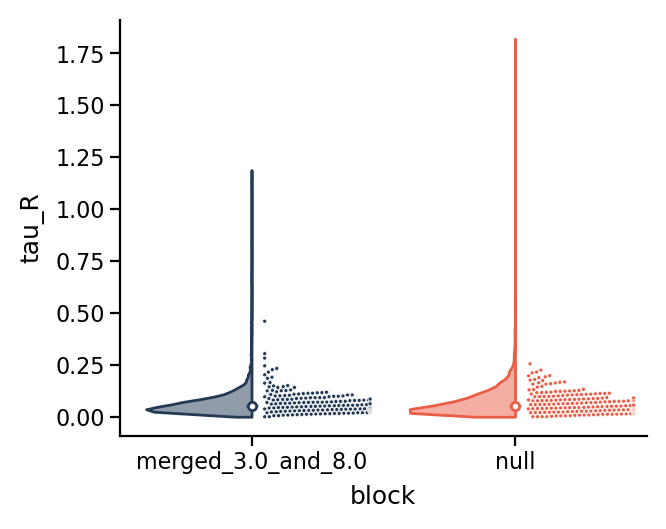

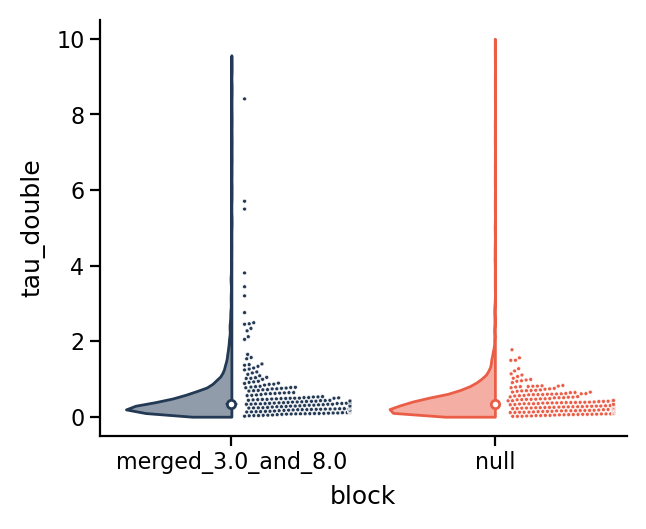

In [5]:
# For natural movie three we do not find such a strong decrease in predictability for later blocks. This could be because the stimulus is shown repeatedly
df = meta_df.query(
    "((stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')) | "
    + "((stimulus == 'spontaneous') & (block == 'null'))"
)

obs = "R_tot"
ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "merged_3.0_and_8.0" : "#233954",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

obs = "tau_R"
ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "merged_3.0_and_8.0" : "#233954",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

obs = "tau_double"
ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "merged_3.0_and_8.0" : "#233954",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)


2024-05-24 22:14:00,533 | INFO     | notebook | <module> | r: 0.336, p: 1.3e-162, m: 0.140, b: 0.067


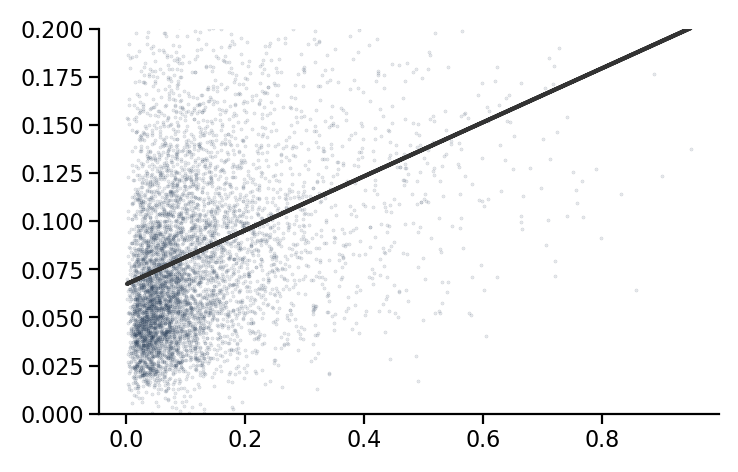

In [6]:
import scipy.stats

df = meta_df.query("stimulus == 'natural_movie_three' & block == 'merged_3.0_and_6.0'")

obs = "R_tot"
df = df.query(f"{obs} == {obs}")
df = df.query("g_dsi_dg == g_dsi_dg")
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.scatter(df["g_dsi_dg"], df[obs], s=0.1, alpha=0.2);
ax.set_ylim(0, 0.2)
# ax.set_xscale("log")

r , p_val = scipy.stats.pearsonr(df["g_dsi_dg"], df[obs])
m, b = np.polyfit(df["g_dsi_dg"], df[obs], 1)

log.info(f"r: {r:.3f}, p: {p_val:.2g}, m: {m:.3f}, b: {b:.3f}")
ax.plot(df["g_dsi_dg"], m*df["g_dsi_dg"] + b, color = ".2")


In [7]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

scipy: 1.13.0

matplotlib    : 3.8.4
logging       : 0.5.1.2
prompt_toolkit: 3.0.42
numpy         : 1.24.4
scipy         : 1.13.0
h5py          : 3.11.0
re            : 2.2.1
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
sqlite3       : 2.6.0
IPython       : 8.22.2
xarray        : 2024.3.0
pandas        : 2.0.3
dask          : 2024.4.2

